<a href="https://colab.research.google.com/github/KhayalM/Extended-Finite-Element-Methods/blob/main/Softening_lc%3D0_75.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Mesh creation and loading

In [ ]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

# You can also use a magic command for a clean restart (clears all variables and re-runs cells above)
# %reset -f

print("All user-defined variables deleted.")

All user-defined variables deleted.


In [ ]:
try:
    import google.colab  # noqa: F401
except ImportError:
    import gmsh
else:
    try:
        import gmsh
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
        import gmsh

--2025-12-16 23:18:14--  https://fem-on-colab.github.io/releases/gmsh-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3497 (3.4K) [application/x-sh]
Saving to: ‘/tmp/gmsh-install.sh’

/tmp/gmsh-install.s 100%[===================>]   3.42K  --.-KB/s    in 0s      

2025-12-16 23:18:14 (24.0 MB/s) - ‘/tmp/gmsh-install.sh’ saved [3497/3497]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ GMSH_INSTALLED=/usr/local/share/fem-on-colab/gmsh.installed
+ [[ ! -f /usr/local/share/fem-on-colab/gmsh.installed ]]
+ H5PY_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/82a9dfcc/releases/h5py-install.sh
+ [[ https://gith

In [ ]:
import gmsh

# Initialize Gmsh
gmsh.initialize()

# Create a new model
gmsh.model.add("I_beam")

# Characteristic length
lc = 0.75  # mesh size

# ------------------------------
# I-beam dimensions (mm)
# ------------------------------
H  = 5.0   # total height
B  = 5.0   # flange width
tf = 1.0   # flange thickness
tw = 3.0   # web thickness

# ------------------------------
# Centering at X = 5 (same logic as before)
# ------------------------------
x_center = 5.0

xL = x_center - B / 2
xR = x_center + B / 2
xwL = x_center - tw / 2
xwR = x_center + tw / 2

# ------------------------------
# Define points (counter-clockwise)
# ------------------------------
points = [
    (xL,   0.0),            # 1 bottom flange left
    (xR,   0.0),            # 2 bottom flange right
    (xR,   tf),             # 3
    (xwR,  tf),             # 4
    (xwR,  H - tf),         # 5
    (xR,   H - tf),         # 6
    (xR,   H),              # 7 top flange right
    (xL,   H),              # 8 top flange left
    (xL,   H - tf),         # 9
    (xwL,  H - tf),         #10
    (xwL,  tf),             #11
    (xL,   tf)              #12
]

for i, (x, y) in enumerate(points, start=1):
    gmsh.model.geo.addPoint(x, y, 0.0, lc, i)

# ------------------------------
# Define lines
# ------------------------------
lines = []
for i in range(1, 12):
    lines.append(gmsh.model.geo.addLine(i, i + 1))
lines.append(gmsh.model.geo.addLine(12, 1))  # close loop

# ------------------------------
# Create surface
# ------------------------------
curve_loop = gmsh.model.geo.addCurveLoop(lines)
surface = gmsh.model.geo.addPlaneSurface([curve_loop])

# Synchronize
gmsh.model.geo.synchronize()

# ------------------------------
# Physical group
# ------------------------------
gmsh.model.addPhysicalGroup(2, [surface], 1)
gmsh.model.setPhysicalName(2, 1, "I_Beam")

# ------------------------------
# Mesh settings
# ------------------------------
gmsh.option.setNumber("Mesh.ElementOrder", 1)
gmsh.option.setNumber("Mesh.Algorithm", 6)

gmsh.model.mesh.generate(2)

# Save mesh
gmsh.write("I_beam_5mm.msh")

# Optional visualization
# gmsh.fltk.run()

# Finalize
gmsh.finalize()


In [ ]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Initialize Gmsh and load the I-beam mesh
# ------------------------------
gmsh.initialize()
gmsh.open("I_beam_5mm.msh")

# ------------------------------
# Get all nodes
# ------------------------------
node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
node_coords = np.array(node_coords).reshape(-1, 3)

# ------------------------------
# Function to get elements of a physical group
# ------------------------------
def get_elements_of_physical_group(dim, tag):
    entity_tags = gmsh.model.getEntitiesForPhysicalGroup(dim, tag)
    all_elements = []

    for entity_tag in entity_tags:
        element_types, element_tags, node_tags_list = gmsh.model.mesh.getElements(dim, entity_tag)

        for i in range(len(element_types)):
            # Linear triangles → 3 nodes per element
            all_elements.append(
                np.array(node_tags_list[i]).reshape(-1, 3)
            )

    return np.concatenate(all_elements) if all_elements else np.array([])

# ------------------------------
# Get elements for the I-beam (physical group 1)
# ------------------------------
elements_I_beam = get_elements_of_physical_group(2, 1)

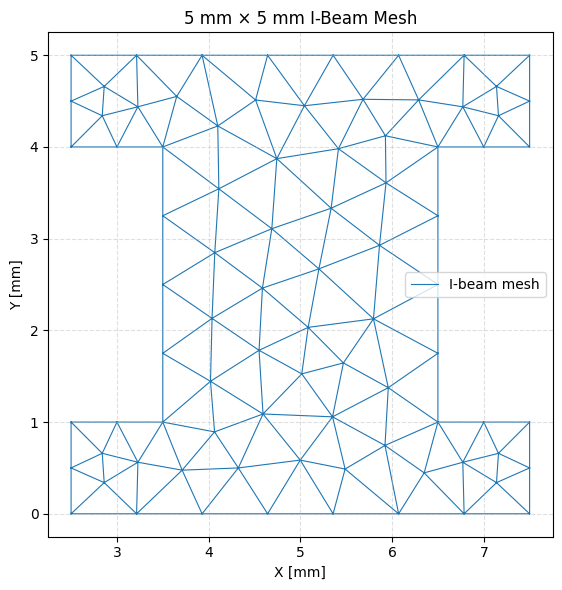

In [ ]:
# ------------------------------
# Mesh visualization
# ------------------------------
plt.figure(figsize=(6, 6))

if elements_I_beam.size > 0:
    plt.triplot(
        node_coords[:, 0],        # x-coordinates
        node_coords[:, 1],        # y-coordinates
        elements_I_beam - 1,   # Gmsh is 1-based → Python is 0-based
        linewidth=0.8,
        label="I-beam mesh"
    )

plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.title("5 mm × 5 mm I-Beam Mesh")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


# 2. Main Functions

In [ ]:
import numpy as np

# ==========================================================
# Jacobian (2 × Area) for a Constant Strain Triangle (CST)
# ==========================================================
def jacobian(coord):
    """
    Compute the absolute value of the Jacobian determinant
    for a 2D linear triangular (CST) element.

    Parameters
    ----------
    coord : ndarray, shape (2, 3)
        Node coordinates of the element:
        coord[0, :] → x-coordinates
        coord[1, :] → y-coordinates

    Returns
    -------
    float
        Absolute value of the Jacobian determinant (2 × element area)
    """
    return abs(
        (coord[0, 0] - coord[0, 2]) * (coord[1, 1] - coord[1, 2]) -
        (coord[0, 1] - coord[0, 2]) * (coord[1, 0] - coord[1, 2])
    )


In [ ]:
# ==========================================================
# Strain–Displacement Matrix (B-matrix) for CST
# ==========================================================
def B_matrix(coord):
    """
    Construct the strain–displacement matrix B for a
    2D Constant Strain Triangle (CST) element.

    Plane strain / plane stress kinematics.

    Parameters
    ----------
    coord : ndarray, shape (2, 3)
        Element node coordinates:
        coord[0, :] → x-coordinates
        coord[1, :] → y-coordinates

    Returns
    -------
    B : ndarray, shape (3, 6)
        Strain–displacement matrix
    """
    x1, x2, x3 = coord[0, :]
    y1, y2, y3 = coord[1, :]

    # Twice the element area (signed)
    A2 = (
        x1 * (y2 - y3) +
        x2 * (y3 - y1) +
        x3 * (y1 - y2)
    )

    # Shape function derivatives (constant over the element)
    dNdx = np.array([
        (y2 - y3) / A2,
        (y3 - y1) / A2,
        (y1 - y2) / A2
    ])

    dNdy = np.array([
        (x3 - x2) / A2,
        (x1 - x3) / A2,
        (x2 - x1) / A2
    ])

    # Assembly of B-matrix
    B = np.zeros((3, 6))
    B[0, 0::2] = dNdx          # ε_xx
    B[1, 1::2] = dNdy          # ε_yy
    B[2, 0::2] = dNdy          # γ_xy
    B[2, 1::2] = dNdx

    return B


In [ ]:
# ==========================================================
# Elastic Constitutive Matrix (Plane Strain)
# ==========================================================
def D_matrix(E, nu):
    """
    Elastic constitutive matrix for isotropic material
    under plane strain conditions.

    Parameters
    ----------
    E : float
        Young's modulus
    nu : float
        Poisson's ratio

    Returns
    -------
    D : ndarray, shape (3, 3)
        Plane strain elasticity matrix
    """
    coef = E / ((1.0 + nu) * (1.0 - 2.0 * nu))

    return coef * np.array([
        [1.0 - nu,     nu,           0.0],
        [nu,           1.0 - nu,     0.0],
        [0.0,          0.0,   0.5 * (1.0 - 2.0 * nu)]
    ])

In [ ]:
# ==========================================================
# Deviatoric Stress (Plane Strain)
# ==========================================================
def deviatoric_part(stress_vector, nu):
    """
    Compute the deviatoric part of the stress tensor
    for plane strain von Mises plasticity.

    Parameters
    ----------
    stress_vector : ndarray, shape (3,)
        [sigma_x, sigma_y, tau_xy]
    nu : float
        Poisson's ratio

    Returns
    -------
    s : ndarray, shape (3,)
        Deviatoric stress vector
    """
    sigma_x, sigma_y, tau_xy = stress_vector

    # Out-of-plane stress (plane strain)
    sigma_z = nu * (sigma_x + sigma_y)

    # Hydrostatic pressure
    p = (sigma_x + sigma_y + sigma_z) / 3.0

    return np.array([
        sigma_x - p,
        sigma_y - p,
        tau_xy
    ])


In [ ]:
# ==========================================================
# Von Mises Equivalent Stress (Plane Strain)
# ==========================================================
def calculate_von_mises_stress(stress_vector, nu):
    """
    Compute von Mises equivalent stress for plane strain.

    Parameters
    ----------
    stress_vector : ndarray, shape (3,)
        [sigma_x, sigma_y, tau_xy]
    nu : float
        Poisson's ratio

    Returns
    -------
    float
        Von Mises equivalent stress
    """
    sigma_x, sigma_y, tau_xy = stress_vector
    sigma_z = nu * (sigma_x + sigma_y)

    return np.sqrt(
        sigma_x**2 + sigma_y**2 + sigma_z**2
        - sigma_x * sigma_y
        - sigma_y * sigma_z
        - sigma_z * sigma_x
        + 3.0 * tau_xy**2
    )


In [ ]:
# ==========================================================
# Yield Function (Isotropic Hardening)
# ==========================================================
def yield_function_plasticity(sigma_eq_tr, kappa, sigma_y0, H):
    """
    Von Mises yield function with isotropic hardening.

    f = sigma_eq - (sigma_y0 + H * kappa)

    Parameters
    ----------
    sigma_eq_tr : float
        Trial equivalent stress
    kappa : float
        Accumulated plastic strain
    sigma_y0 : float
        Initial yield stress
    H : float
        Isotropic hardening modulus

    Returns
    -------
    float
        Value of the yield function
    """
    return sigma_eq_tr - (sigma_y0 + H * kappa)

In [ ]:
# ==========================================================
# Consistent Elastoplastic Tangent (Cep)
# ==========================================================
def compute_Cep(C, stress_vector, H, nu, E):
    """
    Compute the consistent elastoplastic tangent modulus
    for von Mises plasticity with isotropic hardening.

    Parameters
    ----------
    C : ndarray, shape (3, 3)
        Elastic stiffness matrix
    stress_vector : ndarray, shape (3,)
        Current stress state
    H : float
        Isotropic hardening modulus
    nu : float
        Poisson's ratio
    E : float
        Young's modulus

    Returns
    -------
    Cep : ndarray, shape (3, 3)
        Consistent elastoplastic tangent matrix
    """
    # Deviatoric stress
    s = deviatoric_part(stress_vector, nu)

    # Elastic case safeguard
    if np.linalg.norm(s) < 1e-12:
        return C

    # Flow direction
    sigma_eq = calculate_von_mises_stress(stress_vector, nu)
    n_vec = 1.5 * s / sigma_eq
    n = n_vec.reshape(3, 1)

    # Shear modulus
    G = E / (2.0 * (1.0 + nu))

    # Hardening modulus in algorithmic form
    H_star = 3.0 * G + H

    # Consistent tangent operator
    Cep = C - (C @ n @ n.T @ C) / (n.T @ C @ n + H_star)

    return Cep

# 3. Material properties and Boundary conditions

In [ ]:
# ==========================================================
# FEM MODEL SIZE & SOLVER PARAMETERS
# ==========================================================
num_nodes = node_coords.shape[0]          # Total number of mesh nodes
num_elems = elements_I_beam .shape[0]   # Total number of triangular elements
num_dofs  = 2 * num_nodes                 # 2 DOFs per node (u, v)

max_iter = 300                             # Max Newton–Raphson iterations

In [ ]:
# ==========================================================
# MATERIAL PARAMETERS (Plane Strain, von Mises Plasticity)
# ==========================================================
E         = 30e3       # Young's modulus
nu        = 0.3           # Poisson's ratio
sigma_y0 = 50.0            # Initial yield stress

# Elastic constants
G  = E / (2.0 * (1.0 + nu))               # Shear modulus

# Linear softening law (Et < 0)
Et = -E / 20.0
H  = E * Et / (E - Et)                    # Isotropic hardening modulus

# Elastic stiffness matrix
D_el = D_matrix(E, nu)

In [ ]:
# ==========================================================
# STATE VARIABLES
# ==========================================================

U = np.zeros(num_dofs)                    # Global displacement vector
kappa = np.zeros(num_elems)               # Accumulated plastic strain (per element)

current_stress = np.zeros((num_elems, 3))  # [σx, σy, τxy]
current_strain = np.zeros((num_elems, 3))  # [εx, εy, γxy]

In [ ]:

# ==========================================================
# BOUNDARY CONDITIONS IDENTIFICATION
# ==========================================================
y_coords = node_coords[:, 1]
y_max = y_coords.max()
y_min = y_coords.min()

tol = 1e-8
top_nodes    = np.where(np.isclose(y_coords, y_max, atol=tol))[0]
bottom_nodes = np.where(np.isclose(y_coords, y_min, atol=tol))[0]

# --- DOF numbering ---
# u = 2*i, v = 2*i + 1
disp_dofs = 2 * top_nodes + 1             # Prescribed vertical displacement (top)
bottom_x_dofs = 2 * bottom_nodes           # Fixed u at bottom
bottom_y_dofs = 2 * bottom_nodes + 1       # Fixed v at bottom

fixed_dofs = np.concatenate((bottom_x_dofs, bottom_y_dofs))

free_dofs = np.setdiff1d(
    np.arange(num_dofs),
    np.union1d(fixed_dofs, disp_dofs)
)

In [ ]:
# ==========================================================
# LOAD CONTROL PARAMETERS (DISPLACEMENT CONTROL)
# ==========================================================
u_max = -0.015                             # Maximum imposed displacement
num_steps = 200                            # Load increments

sum_R  = np.zeros(num_steps)               # Reaction force history
sum_du = np.zeros(num_steps)               # Displacement history

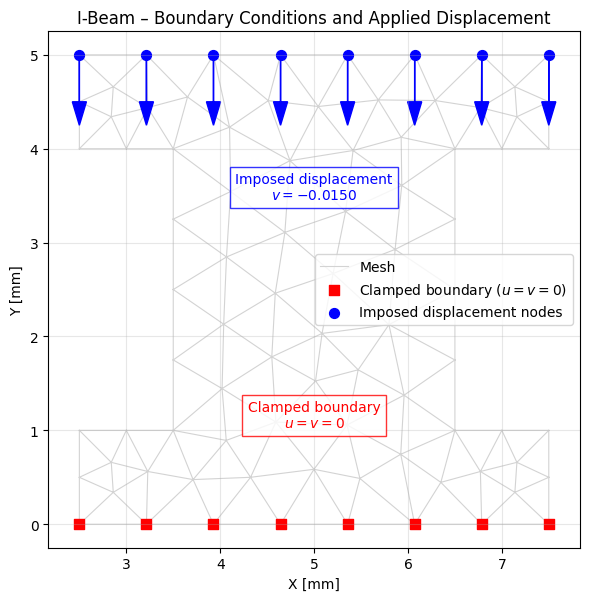

In [ ]:
# ==========================================================
# VISUALIZATION OF BCs AND APPLIED DISPLACEMENT
# ==========================================================
plt.figure(figsize=(6, 8))

x = node_coords[:, 0]
y = node_coords[:, 1]
beam_height = y_max - y_min

# --- Mesh outline ---
plt.triplot(
    x, y,
    elements_I_beam  - 1,
    color="lightgray",
    linewidth=0.8,
    label="Mesh"
)

# --- Clamped bottom boundary ---
plt.scatter(
    x[bottom_nodes],
    y[bottom_nodes],
    color="red",
    marker="s",
    s=60,
    label="Clamped boundary ($u = v = 0$)"
)

# --- Top boundary (imposed displacement) ---
plt.scatter(
    x[top_nodes],
    y[top_nodes],
    color="blue",
    marker="o",
    s=50,
    label="Imposed displacement nodes"
)

# --- Displacement arrows ---
arrow_length = 0.15 * beam_height
for n in top_nodes:
    plt.arrow(
        x[n], y[n],
        0.0, arrow_length * np.sign(u_max),
        head_width=0.15,
        head_length=0.25,
        fc="blue",
        ec="blue",
        length_includes_head=True
    )

# --- Text annotations ---
plt.text(
    np.mean(x[top_nodes]),
    y_max - 0.25 * beam_height,
    rf"Imposed displacement" "\n"
    rf"$v = {u_max:.4f}$",
    ha="center",
    va="top",
    fontsize=10,
    color="blue",
    bbox=dict(facecolor="white", edgecolor="blue", alpha=0.8)
)

plt.text(
    np.mean(x[bottom_nodes]),
    y_min + 0.20 * beam_height,
    "Clamped boundary\n$u = v = 0$",
    ha="center",
    va="bottom",
    fontsize=10,
    color="red",
    bbox=dict(facecolor="white", edgecolor="red", alpha=0.8)
)

# --- Plot settings ---
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.title("I-Beam – Boundary Conditions and Applied Displacement")
plt.legend(loc="center right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# 4. Incremental loading--- Newton-Raphson

In [ ]:
# ==========================================================
# MAIN SOLUTION LOOP (Incremental Newton–Raphson)
# ==========================================================
for step in range(num_steps):

    # ------------------------------------------------------
    # Save converged state from previous load step
    # ------------------------------------------------------
    kappa_old  = kappa.copy()
    stress_old = current_stress.copy()
    strain_old = current_strain.copy()

    # Imposed displacement for current load step
    u_step = u_max * (step + 1) / num_steps

    # Enforce Dirichlet boundary conditions
    U[fixed_dofs] = 0.0
    U[disp_dofs]  = u_step

    iter_count = 0

    # ======================================================
    # Newton–Raphson Iterations
    # ======================================================
    while iter_count < max_iter:

        # Global tangent matrix and residual vector
        K = np.zeros((num_dofs, num_dofs))
        R = np.zeros(num_dofs)      # R = -F_int

        # --------------------------------------------------
        # Element loop
        # --------------------------------------------------
        for e in range(num_elems):

            # --- Element connectivity ---
            n1, n2, n3 = (elements_I_beam [e] - 1).astype(int)

            # --- Element coordinates ---
            element_coord = np.array([
                [node_coords[n1, 0], node_coords[n2, 0], node_coords[n3, 0]],
                [node_coords[n1, 1], node_coords[n2, 1], node_coords[n3, 1]]
            ])

            # --- Kinematics ---
            B_e = B_matrix(element_coord)
            A_e = jacobian(element_coord) / 2.0

            edof = np.array([
                2*n1, 2*n1 + 1,
                2*n2, 2*n2 + 1,
                2*n3, 2*n3 + 1
            ])

            # Element displacement vector
            u_e = U[edof]

            # ==================================================
            # 1. ELASTIC PREDICTOR (Trial State)
            # ==================================================
            strain_e = B_e @ u_e
            delta_strain = strain_e - strain_old[e]

            sigma_trial = stress_old[e] + D_el @ delta_strain
            sigma_eq_tr = calculate_von_mises_stress(sigma_trial, nu)

            # Yield function evaluation
            f_trial = yield_function_plasticity(
                sigma_eq_tr, kappa_old[e], sigma_y0, H
            )

            # ==================================================
            # 2. RETURN MAPPING (Plastic Corrector)
            # ==================================================
            if f_trial <= 1e-8:
                # --- Elastic step ---
                sigma_new = sigma_trial
                kappa_new = kappa_old[e]
                Cep = D_el

            else:
                # --- Plastic step ---
                s_tr = deviatoric_part(sigma_trial, nu)
                n_vec = 1.5 * s_tr / sigma_eq_tr

                # Plastic multiplier increment
                dgamma = f_trial / (3.0 * G + H)

                # Stress correction
                sigma_new = sigma_trial - 2.0 * G * dgamma * n_vec

                # Update accumulated plastic strain
                kappa_new = kappa_old[e] + np.sqrt(2.0 / 3.0) * dgamma

                # Consistent elastoplastic tangent
                Cep = compute_Cep(D_el, sigma_new, H, nu, E)

            # --------------------------------------------------
            # Update element history variables
            # --------------------------------------------------
            kappa[e] = kappa_new
            current_stress[e] = sigma_new

            # ==================================================
            # 3. ELEMENT ASSEMBLY
            # ==================================================
            f_int_e = B_e.T @ sigma_new * A_e
            K_e = B_e.T @ Cep @ B_e * A_e

            # Assemble into global residual and tangent
            for i_local in range(6):
                I = edof[i_local]
                R[I] -= f_int_e[i_local]

                for j_local in range(6):
                    J = edof[j_local]
                    K[I, J] += K_e[i_local, j_local]

        # ======================================================
        # 4. SOLVE LINEARIZED SYSTEM
        # ======================================================
        K_ff = K[np.ix_(free_dofs, free_dofs)]
        R_f  = R[free_dofs]

        delta_U = np.zeros_like(U)

        try:
            delta_U[free_dofs] = np.linalg.solve(K_ff, R_f)
        except np.linalg.LinAlgError:
            print("ERROR: Singular tangent matrix. Aborting iteration.")
            break

        # ------------------------------------------------------
        # Update global displacement vector
        # ------------------------------------------------------
        U[free_dofs] += delta_U[free_dofs]

        # Re-apply Dirichlet boundary conditions
        U[fixed_dofs] = 0.0
        U[disp_dofs]  = u_step

        # Convergence check
        res_norm = np.linalg.norm(delta_U[free_dofs])
        if res_norm < 1e-6:
            break

        iter_count += 1

    # ==========================================================
    # POST-CONVERGENCE: REACTIONS & HISTORY UPDATE
    # ==========================================================
    if iter_count < max_iter:

        R_final = np.zeros(num_dofs)

        for e in range(num_elems):

            n1, n2, n3 = (elements_I_beam [e] - 1).astype(int)
            edof = np.array([
                2*n1, 2*n1 + 1,
                2*n2, 2*n2 + 1,
                2*n3, 2*n3 + 1
            ])

            element_coord = np.array([
                [node_coords[n1, 0], node_coords[n2, 0], node_coords[n3, 0]],
                [node_coords[n1, 1], node_coords[n2, 1], node_coords[n3, 1]]
            ])

            B_e = B_matrix(element_coord)
            A_e = jacobian(element_coord) / 2.0

            # Internal force vector
            f_int_e = B_e.T @ current_stress[e] * A_e

            for i_local in range(6):
                R_final[edof[i_local]] -= f_int_e[i_local]

            # Update converged strain
            current_strain[e] = B_e @ U[edof]

        # Resultant reaction force at clamped boundary
        resultant_reaction = np.sum(R_final[bottom_y_dofs])

        # Store load–displacement history
        sum_R[step]  = resultant_reaction
        sum_du[step] = u_step

        print(
            f"Step {step+1:3d} | "
            f"Reaction = {resultant_reaction:10.3f} | "
            f"Max κ = {kappa.max():.6e}"
        )

    else:
        print(
            f"WARNING: Load step {step+1} did not converge "
            f"after {max_iter} iterations. Simulation stopped."
        )
        sum_R = sum_R[:step]
        sum_du = sum_du[:step]
        break


Step   1 | Reaction =     -1.644 | Max κ = 0.000000e+00
Step   2 | Reaction =     -3.287 | Max κ = 0.000000e+00
Step   3 | Reaction =     -4.931 | Max κ = 0.000000e+00
Step   4 | Reaction =     -6.575 | Max κ = 0.000000e+00
Step   5 | Reaction =     -8.218 | Max κ = 0.000000e+00
Step   6 | Reaction =     -9.862 | Max κ = 0.000000e+00
Step   7 | Reaction =    -11.506 | Max κ = 0.000000e+00
Step   8 | Reaction =    -13.149 | Max κ = 0.000000e+00
Step   9 | Reaction =    -14.793 | Max κ = 0.000000e+00
Step  10 | Reaction =    -16.437 | Max κ = 0.000000e+00
Step  11 | Reaction =    -18.080 | Max κ = 0.000000e+00
Step  12 | Reaction =    -19.724 | Max κ = 0.000000e+00
Step  13 | Reaction =    -21.368 | Max κ = 0.000000e+00
Step  14 | Reaction =    -23.012 | Max κ = 0.000000e+00
Step  15 | Reaction =    -24.655 | Max κ = 0.000000e+00
Step  16 | Reaction =    -26.299 | Max κ = 0.000000e+00
Step  17 | Reaction =    -27.943 | Max κ = 0.000000e+00
Step  18 | Reaction =    -29.586 | Max κ = 0.000

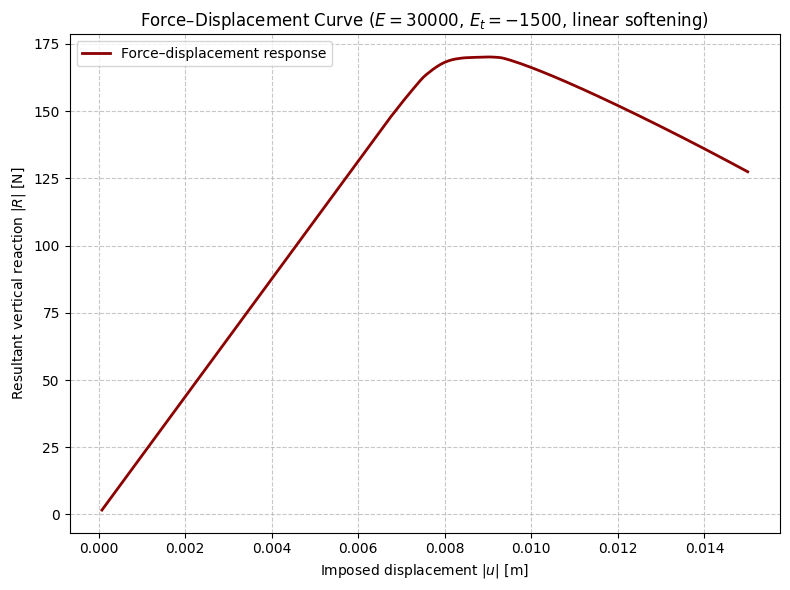

In [ ]:
# ==========================================================
# FORCE–DISPLACEMENT CURVE
# ==========================================================
plt.figure(figsize=(8, 6))

# Plot absolute values (compression / tension symmetry)
plt.plot(
    np.abs(sum_du),
    np.abs(sum_R),
    linewidth=2.0,
    color="darkred",
    label="Force–displacement response"
)

# Labels and title
plt.xlabel(r"Imposed displacement $|u|$ [m]")
plt.ylabel(r"Resultant vertical reaction $|R|$ [N]")
plt.title(
    rf"Force–Displacement Curve "
    rf"($E={E:.0f}$, $E_t={Et:.0f}$, linear softening)"
)

# Formatting
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(loc="best")
plt.tight_layout()

plt.show()


# 5. Saving Data

In [ ]:
# ==========================================================
# FINAL POST-PROCESSING AND DATA EXPORT
# ==========================================================
import pandas as pd

# ---------- LOAD–DISPLACEMENT HISTORY ----------
df_load_disp = pd.DataFrame({
    "imposed_displacement [m]": sum_du,
    "resultant_reaction [N]": sum_R
})

filename = f"Finally_Softened_lc_{lc}.xlsx"

with pd.ExcelWriter(filename, engine="openpyxl") as writer:
    df_load_disp.to_excel(writer, sheet_name="Load_Displacement", index=False)
print(f"\n✔ Results successfully saved to '{filename}'")



✔ Results successfully saved to 'Finally_Softened_lc_0.75.xlsx'


# 6. Plottings

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# ==========================================================
# COMMON PREPARATIONS
# ==========================================================
scale_factor = 25
dofs_per_node = 2

# --- Deformed coordinates ---
U_nodes = U.reshape(num_nodes, dofs_per_node)
deformed_node_coords = node_coords.copy()
deformed_node_coords[:, 0] += U_nodes[:, 0] * scale_factor
deformed_node_coords[:, 1] += U_nodes[:, 1] * scale_factor

# --- Triangulation (zero-based indexing) ---
triang = tri.Triangulation(
    node_coords[:, 0],
    node_coords[:, 1],
    elements_I_beam  - 1
)

# --- Element-wise displacement magnitude ---
nodal_disp_mag = np.linalg.norm(U_nodes, axis=1)
element_disp_mag = np.zeros(num_elems)
for e in range(num_elems):
    node_ids = (elements_I_beam [e] - 1).astype(int)
    element_disp_mag[e] = np.mean(nodal_disp_mag[node_ids])

# --- Element-wise Von Mises stress ---
von_mises = np.zeros(num_elems)
for e in range(num_elems):
    von_mises[e] = calculate_von_mises_stress(current_stress[e], nu)

# --- Stress components (σ_xx, σ_yy, σ_xy) ---
sigma_xx = np.array([current_stress[e, 0] for e in range(num_elems)])
sigma_yy = np.array([current_stress[e, 1] for e in range(num_elems)])
sigma_xy = np.array([current_stress[e, 2] for e in range(num_elems)])

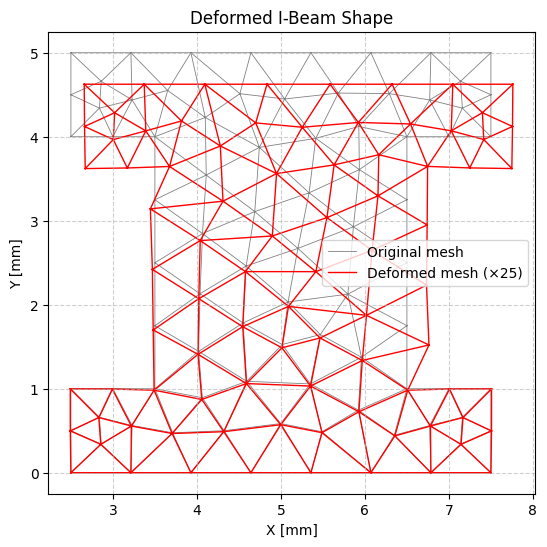

In [ ]:
# ==========================================================
# 1) DEFORMED SHAPE
# ==========================================================
plt.figure(figsize=(10, 6))
plt.triplot(node_coords[:, 0], node_coords[:, 1], elements_I_beam  - 1,
            color="gray", linewidth=0.6, label="Original mesh")
plt.triplot(deformed_node_coords[:, 0], deformed_node_coords[:, 1], elements_I_beam  - 1,
            color="red", linewidth=1.0, label=f"Deformed mesh (×{scale_factor})")
plt.gca().set_aspect("equal")
plt.title("Deformed I-Beam Shape")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


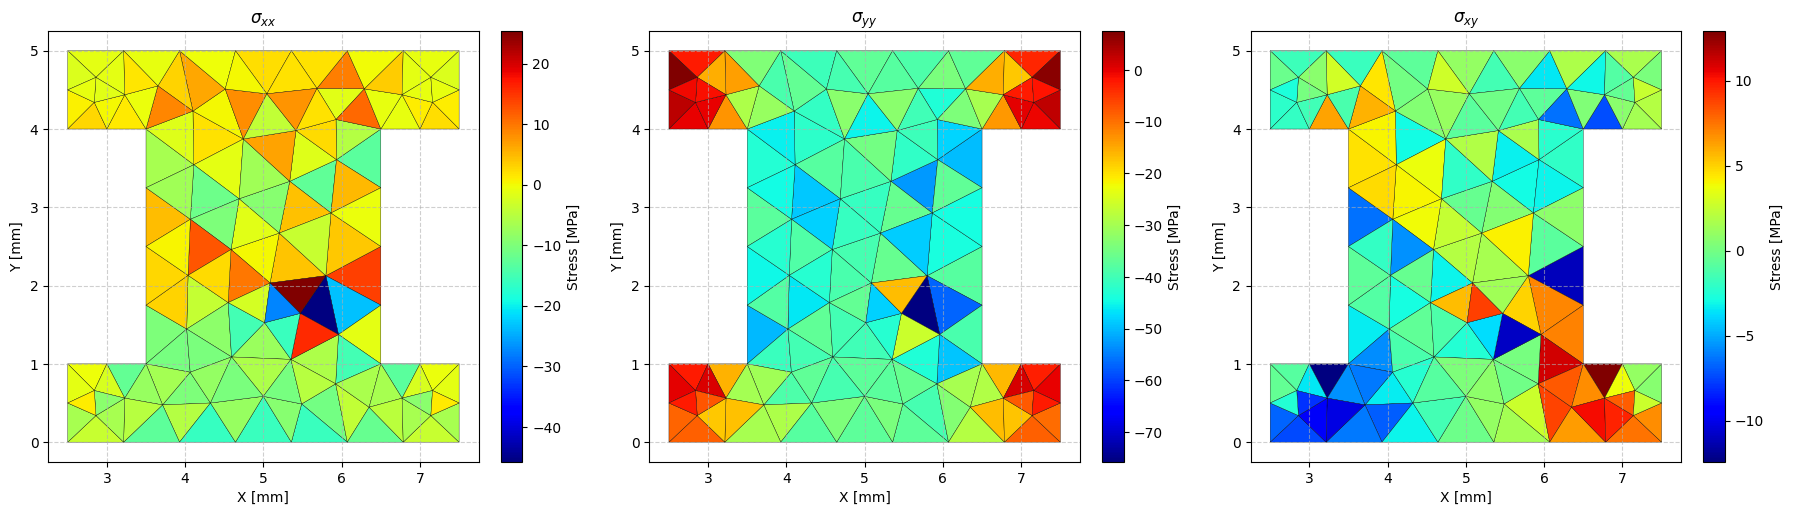

In [ ]:
# ==========================================================
# 2) STRESS FIELDS (σ_xx, σ_yy, σ_xy) SIDE BY SIDE
# ==========================================================
fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

stress_fields = [sigma_xx, sigma_yy, sigma_xy]
titles = [r"$\sigma_{xx}$", r"$\sigma_{yy}$", r"$\sigma_{xy}$"]

for i in range(3):
    pc = axs[i].tripcolor(triang, facecolors=stress_fields[i], edgecolors="k", cmap="jet")
    fig.colorbar(pc, ax=axs[i], label="Stress [MPa]")
    axs[i].set_aspect("equal")
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("X [mm]")
    axs[i].set_ylabel("Y [mm]")
    axs[i].grid(True, linestyle="--", alpha=0.6)

plt.show()

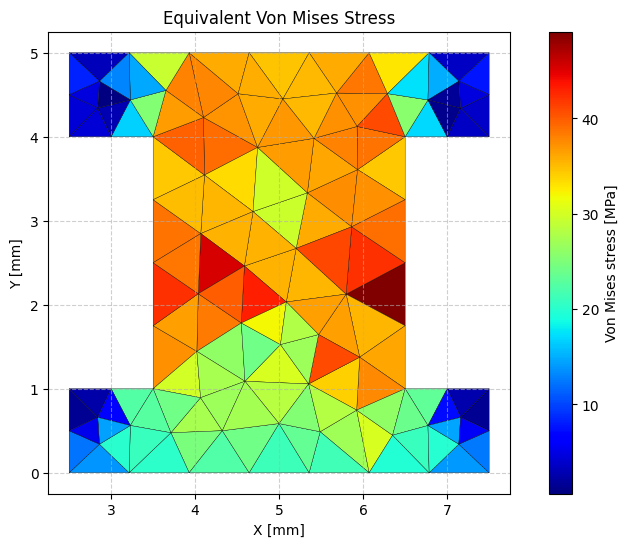

In [ ]:
# ==========================================================
# 3) VON MISES STRESS
# ==========================================================
plt.figure(figsize=(10, 6))
vm_plot = plt.tripcolor(triang, facecolors=von_mises, edgecolors="k", cmap="jet")
plt.colorbar(vm_plot, label="Von Mises stress [MPa]")
plt.gca().set_aspect("equal")
plt.title("Equivalent Von Mises Stress")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

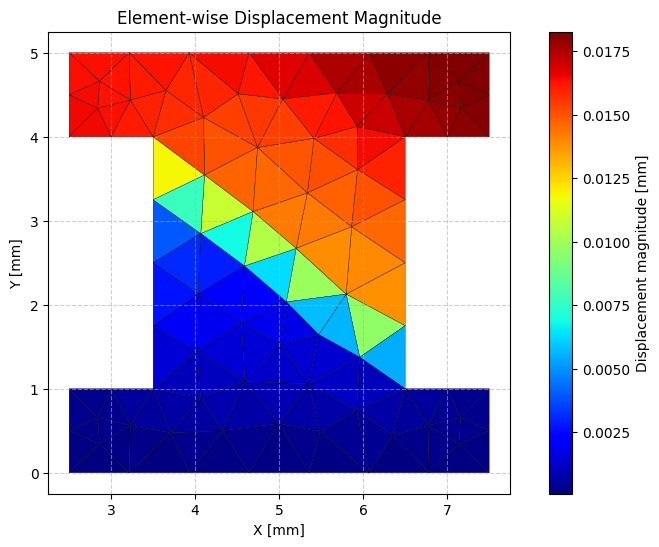

In [ ]:
# ==========================================================
# 4) DISPLACEMENT MAGNITUDE
# ==========================================================
plt.figure(figsize=(10, 6))
disp_plot = plt.tripcolor(triang, facecolors=element_disp_mag, edgecolors="k", cmap="jet")
plt.colorbar(disp_plot, label="Displacement magnitude [mm]")
plt.gca().set_aspect("equal")
plt.title("Element-wise Displacement Magnitude")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()